# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install catboost
!pip install scikit-learn
!pip install ipywidgets
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 4.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 4.2 MB/s 
     |████████████████████████████████| 81 kB 7.3 MB/s 
     |████████████████████████████████| 209 kB 62.5 MB/s 
     |████████████████████████████████| 78 kB 8.1 MB/s 
     |████████████████████████████████| 147 kB 58.1 MB/s 
     |████████████████████████████████| 112 kB 59.9 MB/s 
     |████████████████████████████████| 49 kB 6.5 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256

In [3]:
#загрузим библиотеки

import pandas as pd
import numpy as np
import re
import os
import nltk
from nltk.corpus import stopwords as nltk_stopwords
nltk.download('stopwords')
nltk.download("popular")


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier 

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data] 

In [4]:
# напишем общую функцию для распаковки данных

def open_data(data):
  display(data.head(5))
  print('-------------------------------')
  print('Общая информация')
  data.info()
  print('-------------------------------')
  print('Описание данных')
  display(data.describe())
  print('-------------------------------')
  print('Количество дубликатов')
  print(data.duplicated().sum())

## Подготовка

In [5]:
#загрузим данные

data = pd.read_csv('/content/drive/My Drive/Collab file/toxic_comments.csv')

In [6]:
#посмотрим информацию

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [7]:
data.head(20)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


Пропусков нет, данные выглядят нормально.

0    143346
1     16225
Name: toxic, dtype: int64


Text(0.5, 1.0, 'Распределение целевого признака')

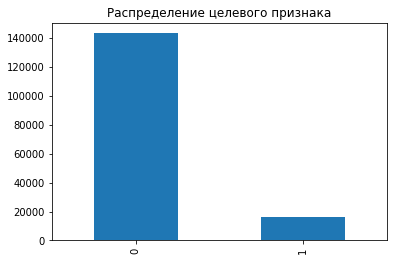

In [8]:
class_frequency = data['toxic'].value_counts()
print(class_frequency)
class_frequency.plot(kind='bar')
plt.title('Распределение целевого признака')

Исходя из графика, мы наблюдаем сильный дисбаланс классов. Радует то, что положительных комментариев гораздо больше. 

### Краткий итог

- Познакомились с данными.
- Пропуски в данных не были обнаружены.
- Присутствует существенный дисбаланс в целевом признаке.
- Сравним модели с балансировкой и без.

### Подготовка данных

In [9]:
#подготовим функцию для очистки текста

def clean_text(text):
    text = re.sub(r'[^a-zA-Z ]', ' ', text)
    #text = " ".join(text.split())
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    
    return text

In [10]:
data['text'] = data['text'].apply(clean_text)

In [11]:
data.head(10)

,text,toxic
0,Explanation Why the edits made under my userna...,0
1,D aww He matches this background colour I m se...,0
2,Hey man I m really not trying to edit war It s...,0
3,More I can t make any real suggestions on impr...,0
4,You sir are my hero Any chance you remember wh...,0
5,Congratulations from me as well use the tools ...,0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word nonsense was offensive to yo...,0
9,alignment on this subject and which are contra...,0


In [12]:
# #подготовим функцию для лемматизации текста

# lemmatizer = WordNetLemmatizer()

# nltk.download('wordnet')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')

# def get_wordnet_pos(word):
#     tag = nltk.pos_tag([word])[0][1][0].upper()
#     tag_dict = {"J": wordnet.ADJ,
#                 "N": wordnet.NOUN,
#                 "V": wordnet.VERB,
#                 "R": wordnet.ADV}
#     return tag_dict.get(tag, wordnet.NOUN)

In [13]:
lemmatizer = WordNetLemmatizer()

def lemmatization(text):
    lemm_list = nltk.word_tokenize(text)
    return ' '.join([lemmatizer.lemmatize(w, 'v') for w in (lemm_list)])

In [14]:
%%time

data['lemmas'] = data['text'].apply(lambda x:lemmatization(x))

CPU times: user 1min 37s, sys: 612 ms, total: 1min 37s
Wall time: 1min 45s


In [15]:
data.head(10)

,text,toxic,lemmas
0,Explanation Why the edits made under my userna...,0,Explanation Why the edit make under my usernam...
1,D aww He matches this background colour I m se...,0,D aww He match this background colour I m seem...
2,Hey man I m really not trying to edit war It s...,0,Hey man I m really not try to edit war It s ju...
3,More I can t make any real suggestions on impr...,0,More I can t make any real suggestions on impr...
4,You sir are my hero Any chance you remember wh...,0,You sir be my hero Any chance you remember wha...
5,Congratulations from me as well use the tools ...,0,Congratulations from me as well use the tool w...
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
7,Your vandalism to the Matt Shirvington article...,0,Your vandalism to the Matt Shirvington article...
8,Sorry if the word nonsense was offensive to yo...,0,Sorry if the word nonsense be offensive to you...
9,alignment on this subject and which are contra...,0,alignment on this subject and which be contrar...


### Краткий итог

- Выполнили очистку текста.
- Выполнили лемматизацию. (В интернете прочитала, что есть опция подбора параметра pos, но по какой-то причине подбор не сработал, выдает ошибку)

На данном этапе этих шагов достаточно.

### Подготовка признаков

In [16]:
#поделим данные на обучающую и тестовую выборки

features = data['lemmas']
target = data['toxic']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=123456, stratify = target)

print('Обучающая выборка: ', features_train.shape,  target_train.shape)
print('Тестовая выборка: ', features_test.shape,  target_test.shape)
print('Количество элементов обучающей выборки: {:.0f}%'.format(features_train.shape[0]/data.shape[0] * 100))
print('Количество элементов тестовой выборки: {:.0f}%'.format(features_test.shape[0]/data.shape[0] * 100))

Обучающая выборка:  (119678,) (119678,)
Тестовая выборка:  (39893,) (39893,)
Количество элементов обучающей выборки: 75%
Количество элементов тестовой выборки: 25%


In [17]:
stop_words = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stop_words)
features_train = count_tf_idf.fit_transform(features_train)
features_test = count_tf_idf.transform(features_test)

### Краткий итог

- Разделили данные на признаки и целевой признак. 
- В обучающую выборку попали 75% данных, в тестовую - 25%.
- Провели векторизацию и добавили список стоп-слов.

## Обучение

Обучим следующие модели:

- Логистическая регрессия
- CatBoostClassifier
- LGBMClassifier
- LinearSVC

In [18]:
# функия для расчёта F1
def f_1 (target, prediction):
    return f1_score(target, prediction)

In [19]:
#для наглядности результатов сведем полученные метрики в таблицу

def metrics(result_train, result_test, model, data):
    data.loc[model, 'F1_train'] = result_train
    data.loc[model, 'F1_test'] = result_test
    return data

In [20]:
# Таблица для сравнения результатов работы моделей
compare_models = pd.DataFrame(columns=['F1_train', 'F1_test'])

In [21]:
score = make_scorer(f1_score,greater_is_better=True)

### Константная модель

In [22]:
%%time

#подготовим константную модель для проверки будущих моделей на адекватность


dummy_model = DummyClassifier(strategy='constant', random_state=None, constant=1)
dummy_model.fit(features_train, target_train)


dummy_model_pred_train = dummy_model.predict(features_train)
dummy_model_pred_test = dummy_model.predict(features_test)


result_dummy_train = f_1(target_train, dummy_model_pred_train)
result_dummy_test = f_1(target_test, dummy_model_pred_test)

print('F1 на обучающей выборке', result_dummy_train)
print('F1 на тестовой выборке', result_dummy_test)

F1 на обучающей выборке 0.18459274765447828
F1 на тестовой выборке 0.18457757855696372
CPU times: user 77.3 ms, sys: 985 µs, total: 78.3 ms
Wall time: 77.6 ms


In [23]:
metrics(result_dummy_train, result_dummy_test, 'DummyClassifier', compare_models)

,F1_train,F1_test
DummyClassifier,0.184593,0.184578


### Логистическая регрессия

In [24]:
%%time

#подберем параметры для Линейной регрессии

model_lr = LogisticRegression(fit_intercept=True, 
                                class_weight='balanced', 
                                random_state=12345,
                                solver='liblinear'
                               )
params_lr = {'C': [-5, 7, 50]}

model_lr_gs = GridSearchCV(model_lr, params_lr, scoring=score)
model_lr_gs.fit(features_train, target_train)


print('Наилучшие параметры для модели Логистической регрессии:', model_lr_gs.best_params_)

Наилучшие параметры для модели Логистической регрессии: {'C': 7}
CPU times: user 1min 4s, sys: 48.7 s, total: 1min 52s
Wall time: 59.5 s


In [25]:
%%time

#обучим модель с подобранными параметрами

model_lr_best = LogisticRegression(fit_intercept=True, 
                                class_weight='balanced', 
                                random_state=12345,
                                solver='liblinear',
                                C=50
                               )
model_lr_best.fit(features_train, target_train)
model_lr_best_pred_train = model_lr_best.predict(features_train)
model_lr_best_pred_test = model_lr_best.predict(features_test)

result_model_lr_train = f_1(target_train, model_lr_best_pred_train)
result_model_lr_target = f_1(target_test, model_lr_best_pred_test)

print('F1 на обучающей выборке', result_model_lr_train)
print('F1 на тестовой выборке', result_model_lr_target)

F1 на обучающей выборке 0.9570494128772953
F1 на тестовой выборке 0.7621519584709768
CPU times: user 8.71 s, sys: 6.75 s, total: 15.5 s
Wall time: 7.95 s


In [26]:
metrics(result_model_lr_train, result_model_lr_target, 'LogisticRegression', compare_models)

,F1_train,F1_test
DummyClassifier,0.184593,0.184578
LogisticRegression,0.957049,0.762152


### CatBoostClassifier

In [27]:
%%time

#не будем применять подбор данных, так как время выполнения очень долгое

model_cb = CatBoostClassifier(loss_function='Logloss',
                    iterations=300,
                    learning_rate=0.9,
                    depth=4,
                    verbose=10,
                    random_state=12345)
model_cb.fit(features_train, target_train)
model_cb_pred_train = model_cb.predict(features_train)
model_cb_pred_test = model_cb.predict(features_test)

result_model_cb_train = f_1(target_train, model_cb_pred_train)
result_model_cb_test = f_1(target_test, model_cb_pred_test)

print('F1 на обучающей выборке', result_model_cb_train)
print('F1 на тестовой выборке', result_model_cb_test)

0:	learn: 0.2807908	total: 1.22s	remaining: 6m 6s
10:	learn: 0.1801267	total: 11.2s	remaining: 4m 53s
20:	learn: 0.1590067	total: 20.9s	remaining: 4m 37s
30:	learn: 0.1465176	total: 30.7s	remaining: 4m 26s
40:	learn: 0.1391415	total: 40.4s	remaining: 4m 15s
50:	learn: 0.1339777	total: 49.9s	remaining: 4m 3s
60:	learn: 0.1289881	total: 59.6s	remaining: 3m 53s
70:	learn: 0.1254596	total: 1m 9s	remaining: 3m 42s
80:	learn: 0.1223881	total: 1m 18s	remaining: 3m 32s
90:	learn: 0.1197374	total: 1m 28s	remaining: 3m 22s
100:	learn: 0.1166979	total: 1m 37s	remaining: 3m 12s
110:	learn: 0.1143973	total: 1m 47s	remaining: 3m 2s
120:	learn: 0.1123307	total: 1m 56s	remaining: 2m 52s
130:	learn: 0.1105182	total: 2m 6s	remaining: 2m 42s
140:	learn: 0.1090288	total: 2m 15s	remaining: 2m 33s
150:	learn: 0.1073978	total: 2m 25s	remaining: 2m 23s
160:	learn: 0.1053128	total: 2m 35s	remaining: 2m 13s
170:	learn: 0.1040945	total: 2m 44s	remaining: 2m 4s
180:	learn: 0.1022440	total: 2m 54s	remaining: 1m 54

In [28]:
metrics(result_model_cb_train, result_model_cb_test, 'CatBoostClassifier',compare_models)

,F1_train,F1_test
DummyClassifier,0.184593,0.184578
LogisticRegression,0.957049,0.762152
CatBoostClassifier,0.841993,0.761317


### LGBMClassifiere

In [29]:
%%time

#подбор параметров производить не будем, т.к. этот процесс на этой модели занимает много времени

model_lgbm = LGBMClassifier(random_state=12345)
model_lgbm.fit(features_train, target_train, verbose=100)
pred_lgbm_train=model_lgbm.predict(features_train)
pred_lgbm_test=model_lgbm.predict(features_test)

result_lgbm_train=f_1(target_train, pred_lgbm_train)
result_lgbm_test=f_1(target_test, pred_lgbm_test)

print('F1 на обучающей выборке', result_lgbm_train)
print('F1 на тестовой выборке', result_lgbm_test)

F1 на обучающей выборке 0.781374002007936
F1 на тестовой выборке 0.744455718220032
CPU times: user 2min 10s, sys: 512 ms, total: 2min 11s
Wall time: 1min 7s


In [30]:
metrics(result_lgbm_train, result_lgbm_test, 'LGBMClassifier',compare_models)

,F1_train,F1_test
DummyClassifier,0.184593,0.184578
LogisticRegression,0.957049,0.762152
CatBoostClassifier,0.841993,0.761317
LGBMClassifier,0.781374,0.744456


### LinearSVC 

In [31]:
%time

#найдем параметры для модели

model_cvs = LinearSVC(random_state=12345, class_weight='balanced')

params_cvs = [{'C': [0.5, 0.4, 0.3]}]


grid_cvs = GridSearchCV(model_cvs, params_cvs, scoring=score, n_jobs=-1, 
                   cv=5, verbose=True)
grid_cvs.fit(features_train, target_train)

print('Наилучшие параметры для модели LinearSVC:', grid_cvs.best_params_)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Наилучшие параметры для модели LinearSVC: {'C': 0.5}


In [32]:
%%time

#обучим модель с подобранными параметрами

model_cvs_best = LinearSVC(random_state=12345, class_weight='balanced', C=0.3)
model_cvs_best.fit(features_train, target_train)
model_cvs_best_pred_train = model_cvs_best.predict(features_train)
model_cvs_best_target = model_cvs_best.predict(features_test)

result_model_cvs_train = f_1(target_train, model_cvs_best_pred_train)
result_model_cvs_target = f_1(target_test, model_cvs_best_target)

print('F1 на обучающей выборке', result_model_cvs_train)
print('F1 на тестовой выборке', result_model_cvs_target)

F1 на обучающей выборке 0.8809358435386585
F1 на тестовой выборке 0.7621283255086072
CPU times: user 1.97 s, sys: 11 ms, total: 1.98 s
Wall time: 1.98 s


In [33]:
metrics(result_model_cvs_train, result_model_cvs_target, 'LinearSVC',compare_models)

,F1_train,F1_test
DummyClassifier,0.184593,0.184578
LogisticRegression,0.957049,0.762152
CatBoostClassifier,0.841993,0.761317
LGBMClassifier,0.781374,0.744456
LinearSVC,0.880936,0.762128


### Краткий итог

- Были обучены 4 модели.
- Для моделей Логистрическая регрессия и LinearSVC был произведен подбор параметров с помощью GridSearch.
- Результаты F1 были объеденины в сводную таблицу для сравнения.
- Все модели кроме LGBMClassifier соответствуют требованиям задания.
- На обучающей выборке наилучший результат показа Линейная регрессия.
- На тестовой выборке наилучший результат также показала Линейная регрессия, хотя CatBoost и LinearCVS 
- Модели были сравнены с константной моделью, и результат показывает, что все модели адекватны.

## Выводы

По результатам обучения моделей наилучший результат на тестовой выборке получился у модели Линейной регрессии. Вероятно, если бы удалось сделать подбор параметров для модели CatBoost, то результат финального сравнения мог бы быть совсем другим. Также интересно, что наилучшие результаты показали модели, для которых подбор параметров был произведен. По итогам проекта я рекомендую выбрать к работе модель Линейной регрессии.